In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, uniform, bernoulli, gaussian_kde, beta
import matplotlib.pyplot as plt
# import random
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# target distribution for mcmc
class multivariate_beta:
    def __init__(self,params):
        self.R = beta(params[0][0],params[0][1])
        self.G = beta(params[1][0],params[1][1])
        self.B = beta(params[2][0],params[2][1])
        self.params = params
    def pdf(self,xint):
        # xint is a 3-tuple with value range [0,255]
        # convert to ~range [0,1]
        # (actually [.5/256,(256-.5)/256], so that pdf gives 'median value' over relevant range)
        x = [(float(c)+.5)/256 for c in xint]
        density = self.R.pdf(x[0])*self.G.pdf(x[1])*self.B.pdf(x[2])
#         print (x,density)
        return density
    def mean(self):
        return [float(a)/(a+b)*256 for a,b in self.params]
    def std(self):
        return [((float(a)*b)/(((a+b)**2)*(a+b+1)))**(.5)*256 for a,b in self.params]

# target distribution params
target_params = [(3,9),(9,1),(10,10)]
targetdist = multivariate_beta(target_params)
print targetdist.mean()
print targetdist.std()

[64.0, 230.4, 128.0]
[30.74460553057673, 23.156071263572247, 27.931889950207022]


In [6]:
# simulating 50 subject mcmcs, with optional acceptance error

num_subjects = 50  # number of subjects / mcmc repetitions
error_rate = 0     # acceptance error rate
burn_in_time = 30  # burn-in time

# proposal distribution parameters
sd_prop = 50
cov_prop = np.diag([sd_prop**2]*3)

# valid MCMC samples collected here
samples = []

# simulate mcmc sequence for each subject
for subject_mcmc in range(num_subjects):
    # draw initial sample from uniform
    x_t = (uniform().rvs(size=3)*256).astype(int)

    for numQ in range(120):
        # draw sample from proposal distribution, 
        x_proposal = multivariate_normal(x_t,cov_prop).rvs().astype(int)
        
        # resample from proposal distribution if out-of-bounds
        while any(xi<0 or xi>255 for xi in x_proposal):
            x_proposal = multivariate_normal(x_t,cov_prop).rvs().astype(int)
            
        # accept with probability A(x_proposal,x_t)
        A = targetdist.pdf(x_proposal)/(targetdist.pdf(x_proposal)+targetdist.pdf(x_t))
        
        # accept proposal
        if bernoulli(A).rvs() ^ bernoulli(error_rate).rvs():
            # new MCMC state
            x_t = x_proposal
            # start sampling after 30th proposal
            if numQ>burn_in_time:
                samples.append(x_proposal)
            

# MCMC samples and color components
samples = np.array(samples)
R,G,B = samples.T

# sample statistics on individual component distributions
print "Mean: ({0:.2f},{1:.2f},{2:.2f})".format(np.mean(R),np.mean(G),np.mean(B))
print "Std: ({0:.2f},{1:.2f},{2:.2f})".format(np.std(R),np.std(G),np.std(B))


Mean:(66.33,218.69,127.67)
Std:(32.51,29.81,30.51)


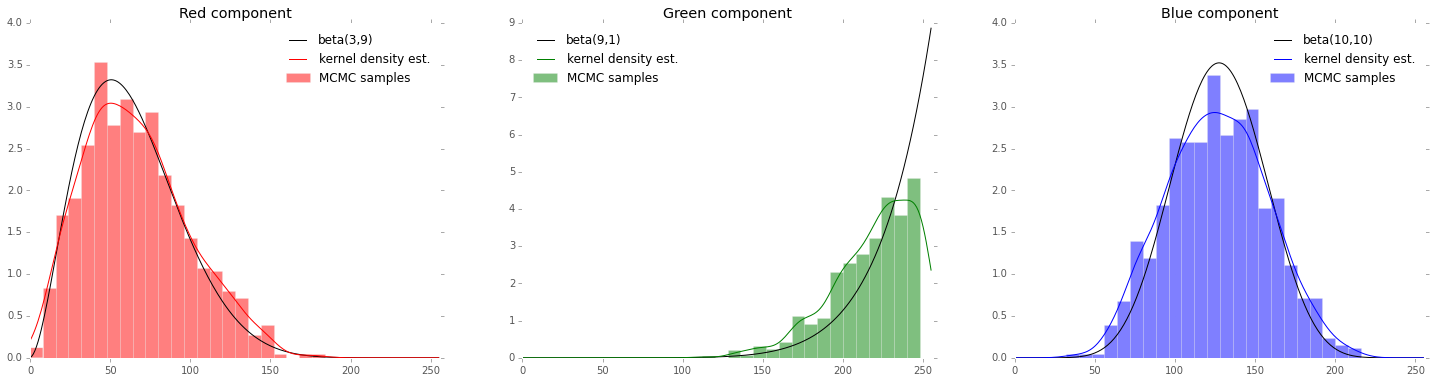

In [33]:
# Plotting component distributions

data = [R,G,B]
RGBname = ['Red','Green','Blue']
RGBcode = ['r','g','b']

fig = plt.figure(figsize=(25,6))
for dim in range(3):
    
    # comparing mcmc samples and real distribution, by projection
    projection = data[dim]#[200:]
    
    ax = fig.add_subplot(1,3,dim+1)
    ax.set_xlim(0,256)

    # target distribution
    rv = beta(targetdist.params[dim][0],targetdist.params[dim][1])
    linspace = [(i+.5)/256 for i in range(256)]
    ax.plot(range(256),rv.pdf(linspace),'k-',
            label='beta({0},{1})'.format(targetdist.params[dim][0],targetdist.params[dim][1]))

    # kernel density estimate
    kernel = gaussian_kde(projection)
    normfactor = kernel.integrate_box_1d(0,256)
    kernel = kernel(range(256))*256/normfactor
    ax.plot(range(256),kernel,'{0}-'.format(color),label='kernel density est.')

    # histogram, bin width=32
    plt.hist(projection,bins=range(0,256,8),
             weights=np.repeat(32.0/len(projection),len(projection)),
             label='MCMC samples',alpha=0.5,
             color=RGBcode[dim]
            )

    # legend
    ax.legend(loc=0);
    plt.title('{0} component'.format(colorname[dim]))


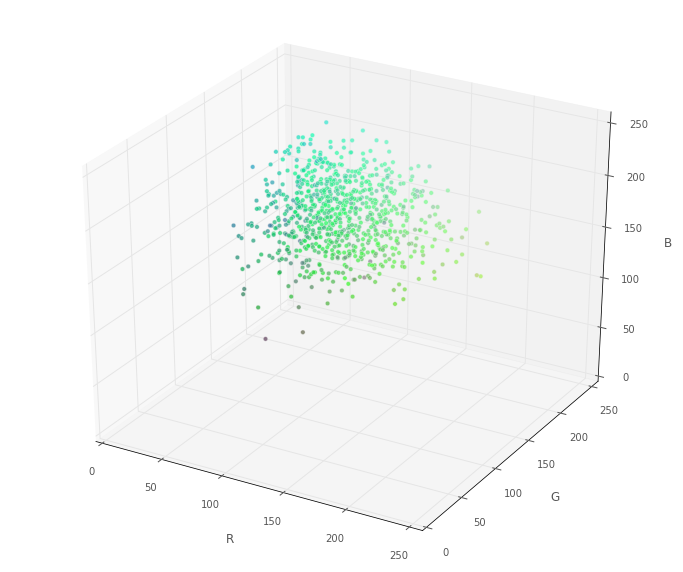

In [8]:
# 3D color space plot
fig = plt.figure(1,figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,255);ax.set_ylim(0,255);ax.set_zlim(0,255)
ax.set_xlabel('R');ax.set_ylabel('G');ax.set_zlabel('B')
# ax.plot(xs=R,ys=G,zs=B,c='#999999',alpha=.5)
ax.scatter(xs=R,ys=G,zs=B,c=samples.astype(float)/256, alpha=.7)